# Detecting Sleep States solution using 1D Convolutional Neural Network

- is_submission: determines whether we want a kaggle submittable csv or just an evaluation

In [1]:
is_submission = False

In [2]:
if is_submission:
    data_root = '/kaggle/input/child-mind-institute-detect-sleep-states'

#### Download testing dataset

In case we are not doing a submission, we want to download the training and test data that we hand crafted from the original data to locally evaluate our new model.

In [3]:
def download_data():
  !mkdir data
  !wget -O data/train_events.csv "https://www.dropbox.com/scl/fi/zo7q4t5bhlakuxoh6a4ys/train_events.csv?rlkey=zbcvut5w2zsw0pdo5jliyokg9&dl=0"
  !wget -O data/train_series.parquet "https://www.dropbox.com/scl/fi/xqvzofoos3nty3m0lsvr2/train_series.parquet?rlkey=g0cd8cymbjrve9wy06213un36&dl=0"
  !wget -O data/test_events.csv "https://www.dropbox.com/scl/fi/pqqxr3kwxp11n4hnsqs6o/test_events.csv?rlkey=uej32itkf7cx16ykvxwfgcs4h&dl=0"
  !wget -O data/test_series.parquet "https://www.dropbox.com/scl/fi/cifdom9qg3ui0gtiznfi0/test_series.parquet?rlkey=caj8avqzwzv42l4bfb6ucjjjw&dl=0"

if not is_submission:
  download_data()
  data_root = 'data'

mkdir: cannot create directory ‘data’: File exists
--2023-12-10 17:06:06--  https://www.dropbox.com/scl/fi/zo7q4t5bhlakuxoh6a4ys/train_events.csv?rlkey=zbcvut5w2zsw0pdo5jliyokg9&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8efbab8128c66e984bf2e39701.dl.dropboxusercontent.com/cd/0/inline/CJJ9UcryrApNwghPec9gnUUGmvHBjfJLJKEMME6LgEHmu42Vc9POBqC0V8d7DxC9zVkllUAR9TapHwwLY9WACWQJYAfc8sBSI6CgmZIkOzk5eZ7S1ToIxdne-WMJMxfpkwU/file# [following]
--2023-12-10 17:06:07--  https://uc8efbab8128c66e984bf2e39701.dl.dropboxusercontent.com/cd/0/inline/CJJ9UcryrApNwghPec9gnUUGmvHBjfJLJKEMME6LgEHmu42Vc9POBqC0V8d7DxC9zVkllUAR9TapHwwLY9WACWQJYAfc8sBSI6CgmZIkOzk5eZ7S1ToIxdne-WMJMxfpkwU/file
Resolving uc8efbab8128c66e984bf2e39701.dl.dropboxusercontent.com (uc8efbab8128c66e984bf2e39701.dl.dropboxusercontent.com)...

### Imports

- os: to handle file system paths
- gc: garbage collector to free up space mid-run
- pyarrow: parquet reading
- pandas: data analysis
- numpy: calculations

In [ ]:
! pip install pandas, numpy, matplotlib, sklearn, tensorflow

In [4]:
from os import path
import gc
import pandas as pd
import numpy as np

ModuleNotFoundError: No module named 'pandas'

data_root: the path to the directory containing the train and test data

### Importing the training events

train_events: contains the data from train_events.csv, this includes:
- **series_id (str)**: id of a series corresponding to a person's readings
- **night (int)**: nth night in a given series
- **event (str)**: either onset or wakeup
- **step (int)**: there is 1 reading in the train_series every 5 seconds, 1 step is this interval

series_list: all the unique series_ids in one list

In [64]:
train_events = pd.read_csv(
    path.join(data_root, 'train_events.csv'),
    dtype={
        'series_id': 'str',
        'night': 'Int32',
        'event': 'str',
        'step': 'Int64',
    }
)
series_list = train_events['series_id'].unique()
print(len(series_list))

247


### Preprocessing the training events

Drop events without time information. We do this because an **event without time information means there was no sleep recorded** for the given night.

In [65]:
train_events = train_events.dropna(axis=0)
train_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8525 entries, 0 to 12965
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8525 non-null   int64 
 1   series_id   8525 non-null   object
 2   night       8525 non-null   Int32 
 3   event       8525 non-null   object
 4   step        8525 non-null   Int64 
 5   timestamp   8525 non-null   object
dtypes: Int32(1), Int64(1), int64(1), object(3)
memory usage: 449.6+ KB


#### Filter out invalid nights

An invalid night is a night where either the **onset or wakeup time is missing**.

In [66]:
bad_nights = train_events[['series_id', 'night', 'event']].groupby(by=['series_id', 'night']).count()
bad_nights = bad_nights[bad_nights['event']!=2].reset_index()
print(bad_nights)

      series_id  night  event
0  0ce74d6d2106     20      1
1  154fe824ed87     30      1
2  44a41bba1ee7     10      1
3  efbfc4526d58      7      1
4  f8a8da8bdd00     17      1


In [67]:
bad_series = bad_nights['series_id'].unique()

In [68]:
print(bad_series)

['0ce74d6d2106' '154fe824ed87' '44a41bba1ee7' 'efbfc4526d58'
 'f8a8da8bdd00']


In [69]:
train_events = train_events[~(train_events['series_id'].isin(bad_series))]

In [70]:
series_list = train_events['series_id'].unique()
print(series_list[:10])
print(len(series_list))

['038441c925bb' '03d92c9f6f8a' '0402a003dae9' '04f547b8017d'
 '062cae666e2a' '062dbd4c95e6' '08db4255286f' '0a96f4993bd7'
 '0cd1e3d0ed95' '0cfc06c129cc']
234


### Importing the training time series

train_series: contains the data from train_series.parquet, this includes:
- **series_id (str)**: id of a series corresponding to a person's readings
- **anglez (float)**: z-angle is a metric that refers to the angle of the arm relative to the vertical axis of the body
- **enmo (float)**: Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero

not included:
- **step (int)**: there is 1 reading in the train_series every 5 seconds, 1 step is this interval
- **timestamp (timestamp)**: the time of the reading
we do not need time information as there is no causation between sleep state changes and time

In [71]:
train_series = pd.read_parquet(path.join(data_root, 'train_series.parquet'), columns=['series_id', 'anglez', 'enmo'])

### Standardization

Using the **StandardScaler** from sklearn.preprocessing we can easily standardize our dataset to have the properties:
- mean = 0
- std = 1

In [72]:
if not is_submission: train_series.describe([])

In [73]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
input_scaler = scaler.fit(train_series[['anglez', 'enmo']])
train_series[['anglez', 'enmo']] = scaler.transform(train_series[['anglez', 'enmo']])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

In [74]:
if not is_submission: train_series.describe([])

In [75]:
event_map = {}
for series_id, events in train_events.groupby('series_id'):
    event_map[series_id] = events.drop(columns=['series_id', 'timestamp']).reset_index(drop=True)

In [76]:
series_map = {}
for series_id, series in train_series.groupby('series_id'):
    series_map[series_id] = series[['enmo', 'anglez']].to_numpy()

In [77]:
train_series = None
gc.collect()

0

### Sampling data

In [78]:
import random
import matplotlib.pyplot as plt

In [132]:
FRAME_SIZE = 60 * 12 # frame width
MIN_NONE_SAMPLE_INTERVAL = 4 * 60 * 12 # minimum steps between events to sample none frames from
NONE_PADDING = 30 * 12 # padding between events and none frames
EVENT_SAMPLE_FRAMES = 5 # event margin to frame edges
EVENT_SAMPLE_STRIDE = 3 * 12 # event sampling stride

In [124]:
# Extracts samples between two events
def sample_between(start, end, n_samples, padding=NONE_PADDING) -> list[tuple[int]]:
    samples = []
    gap = (end - start - 2 * padding - n_samples * FRAME_SIZE) // (n_samples - 1)
    stride = gap + FRAME_SIZE
    for frame_start in range(start + padding, end - FRAME_SIZE - padding + 1, stride):
        samples.append((frame_start, frame_start+FRAME_SIZE))
    return samples

In [125]:
# Extracts samples around an event
def sample_around(event, frames, stride) -> list[list]:
    samples = []
    for i in range(-EVENT_SAMPLE_FRAMES, EVENT_SAMPLE_FRAMES + 1):
        d = i * EVENT_SAMPLE_STRIDE
        start = event - FRAME_SIZE // 2 + d
        samples.append((start, start + FRAME_SIZE))
    return samples

In [ ]:
def display_sampling(series_id):
    series = series_map[series_id]
    events = event_map[series_id]
    plt.figure(figsize=(200, 4))
    plt.title(f'Frame sampling for series {series_id}')

    last_event_step = 0
    for i in range(len(events)):
        step = events['step'][i]
        type = events['event'][i]

        event_color = 'green' if type == 'onset' else 'red'
        plt.axvline(step, color=event_color, lw=0.5)

        event_samples = sample_around(step, EVENT_SAMPLE_MARGIN, EVENT_SAMPLE_STRIDE)
        for frame_start, frame_end in event_samples:
            plt.axvspan(frame_start, frame_end, color=event_color, alpha=0.05)

        if step - last_event_step >= MIN_NONE_SAMPLE_INTERVAL:
            n_samples = len(event_samples) // 2
            for frame_start, frame_end in sample_between(last_event_step, step, n_samples):
                if frame_start < 0 or frame_end >= series.shape[0]:
                    continue
                plt.axvspan(frame_start, frame_end, color='black', alpha=0.1)
        last_event_step = step
    plt.plot(series, lw=0.5)

if not is_submission:
    display_sampling(series_list[0])

In [135]:
X_none = []
X_onset = []
X_onset_time = []
X_wakeup = []
X_wakeup_time = []
for series_id, events in event_map.items():
    series = series_map[series_id]

    last_event_step = 0
    for i in range(len(events)):
        step = events['step'][i]
        type = events['event'][i]

        event_samples = sample_around(step, EVENT_SAMPLE_MARGIN, EVENT_SAMPLE_STRIDE)
        for frame_start, frame_end in event_samples:
            if frame_start < 0 or frame_end >= series.shape[0]:
                continue
            if type == 'onset':
                X_onset.append(series[frame_start:frame_end])
                X_onset_time.append(step - frame_start)
            if type == 'wakeup':
                X_wakeup.append(series[frame_start:frame_end])
                X_wakeup_time.append(step - frame_start)
        if step - last_event_step >= MIN_NONE_SAMPLE_INTERVAL:
            n_samples = len(event_samples) // 2
            for frame_start, frame_end in sample_between(last_event_step, step, n_samples):
                if frame_start < 0 or frame_end >= series.shape[0]:
                    continue
                X_none.append(series[frame_start:frame_end])
        last_event_step = step

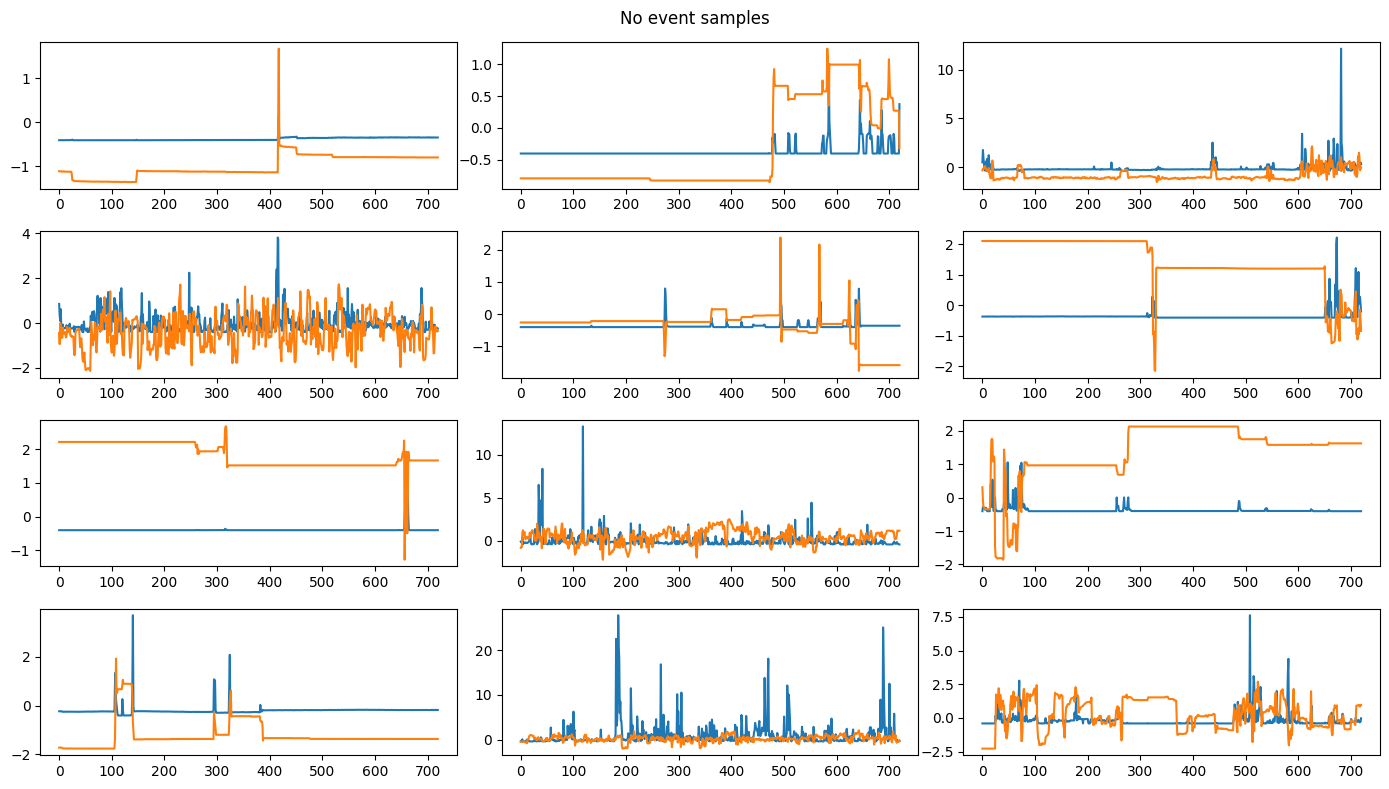

In [138]:
def plot_none_samples(samples):
    cols = 3
    rows = 4
    fig, ax = plt.subplots(rows, cols, figsize=(14, 8))
    for i in range(rows):
        for j in range(cols):
            ax[i][j].plot(samples[j * rows + i])
    plt.suptitle('No event samples')
    plt.tight_layout()
    plt.show()

if not is_submission:
    plot_none_samples(random.sample(X_none, 12))

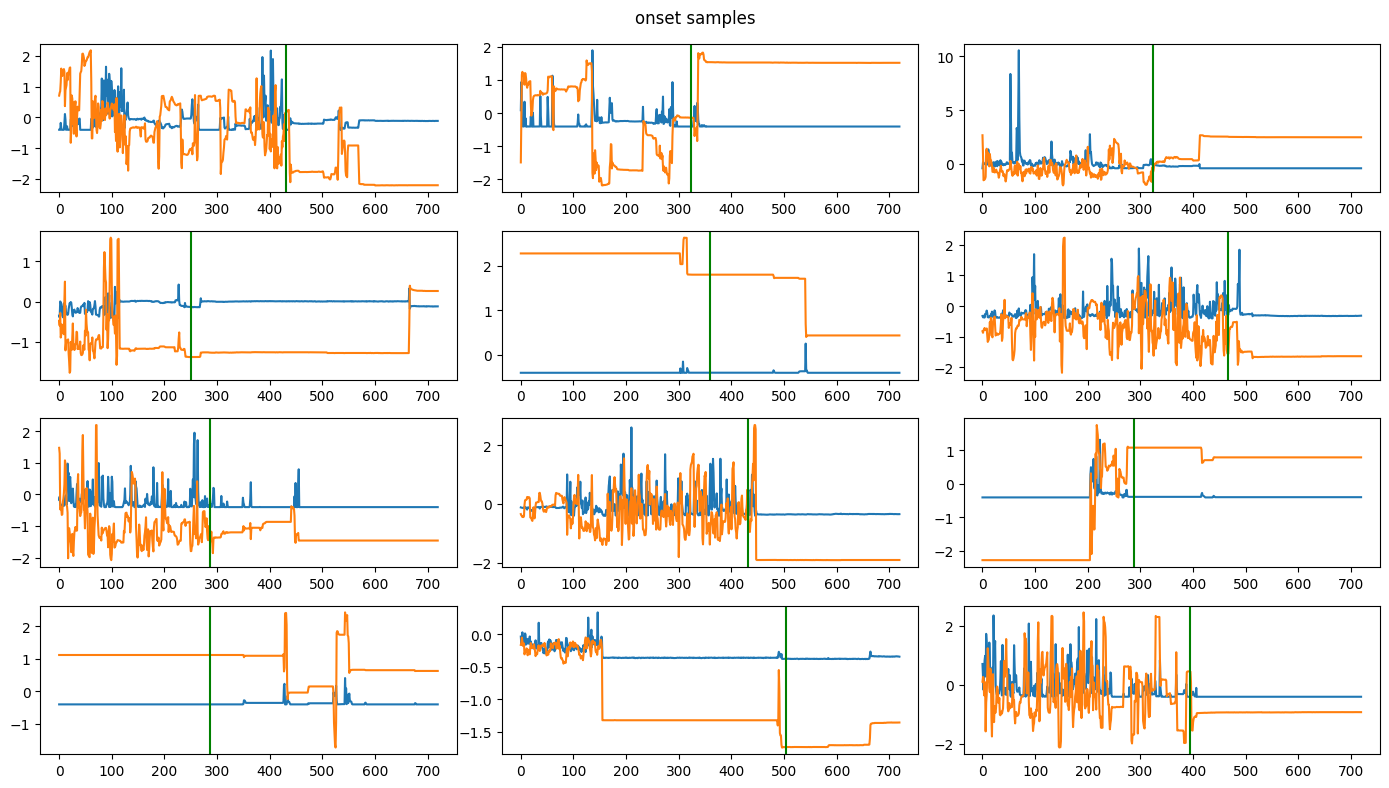

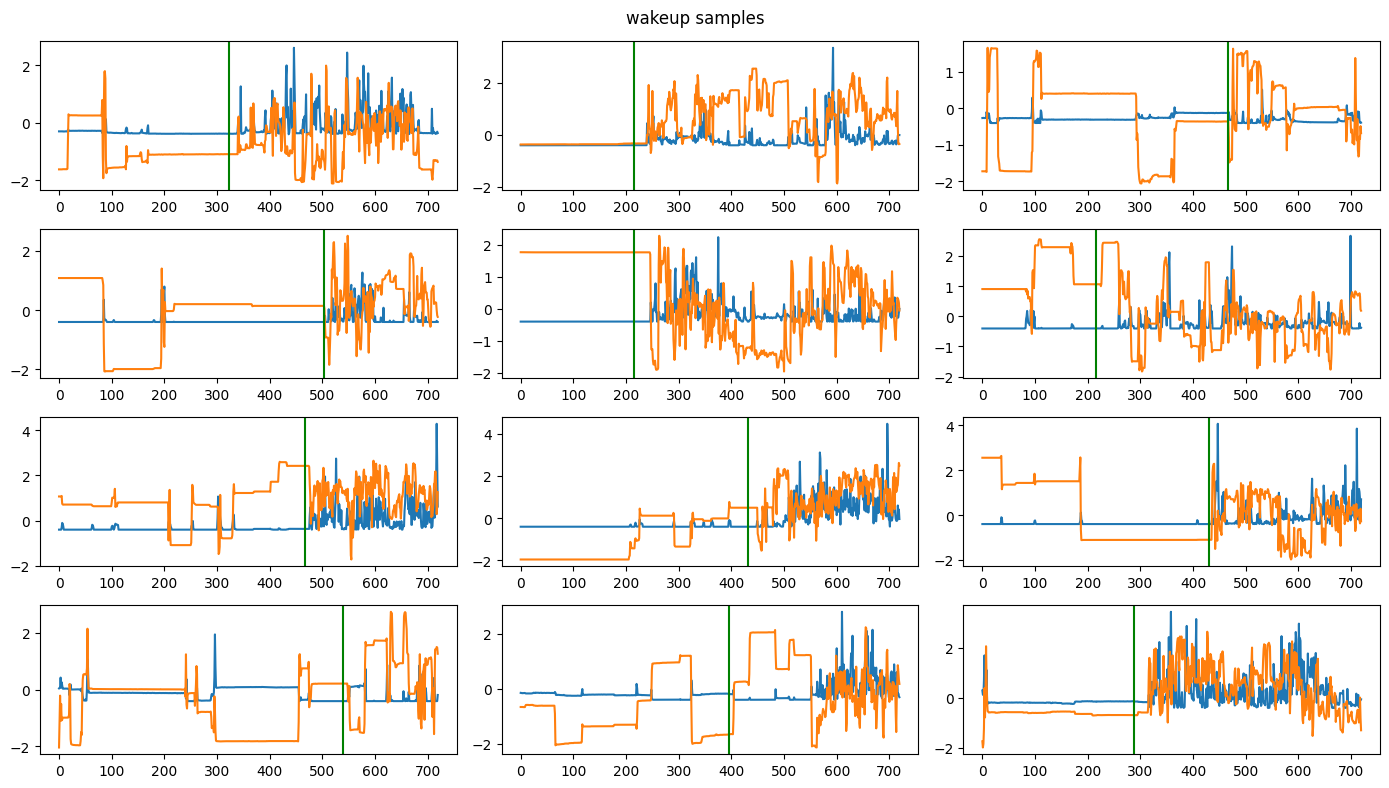

In [85]:
def plot_event_samples(type, samples: list[tuple]):
    cols = 3
    rows = 4
    _, ax = plt.subplots(rows, cols, figsize=(14, 8))
    for i in range(rows):
        for j in range(cols):
            sample = samples[j * rows + i]
            ax[i][j].plot(sample[0])
            ax[i][j].axvline(sample[1], c='green')
    plt.suptitle(f'{type} samples')
    plt.tight_layout()
    plt.show()

if not is_submission:
    plot_event_samples('onset', random.sample(list(zip(X_onset, X_onset_time)), 12))
    plot_event_samples('wakeup', random.sample(list(zip(X_wakeup, X_wakeup_time)), 12))

### Assembling the dataset

In [139]:
n_samples = len(X_none) + len(X_onset) + len(X_wakeup)
n_features = 2

X = np.empty([n_samples, FRAME_SIZE, n_features], dtype=np.float32) # input
Y = np.zeros([n_samples, 3], dtype=np.float32) # labels

idx = 0
def fill_data(x, y_idx):
    global idx
    n = len(x)
    X[idx:idx + n] = x
    Y[idx:idx + n, y_idx] = 1.0
    idx += n

fill_data(X_none, 0)
fill_data(X_onset, 1)
fill_data(X_wakeup, 2)

In [140]:
print(X.shape)
print(Y.shape)

(132701, 720, 2)
(132701, 3)


In [141]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05)
print(len(X_train), len(Y_train))
print(len(X_test), len(Y_test))

126065 126065
6636 6636


In [142]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the model
model = Sequential()
model.add(Conv1D(128, 4, activation='relu', input_shape=(FRAME_SIZE, n_features)))
model.add(MaxPooling1D(4))
model.add(Conv1D(64, 4, activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint("model.hdf5", save_best_only=True)
network_history = model.fit(X_train, Y_train, epochs=5, validation_split=0.15, batch_size=64, verbose=1, callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
1675/1675 [==============================] - 13s 7ms/step - loss: 0.2864 - accuracy: 0.9067 - val_loss: 0.2359 - val_accuracy: 0.9243
Epoch 2/5
  10/1675 [..............................] - ETA: 9s - loss: 0.1994 - accuracy: 0.9328 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1675/1675 [==============================] - 10s 6ms/step - loss: 0.2344 - accuracy: 0.9251 - val_loss: 0.2289 - val_accuracy: 0.9249
Epoch 3/5
1675/1675 [==============================] - 10s 6ms/step - loss: 0.2208 - accuracy: 0.9295 - val_loss: 0.2111 - val_accuracy: 0.9296
Epoch 4/5
1675/1675 [==============================] - 10s 6ms/step - loss: 0.2089 - accuracy: 0.9327 - val_loss: 0.2118 - val_accuracy: 0.9304
Epoch 5/5
1675/1675 [==============================] - 10s 6ms/step - loss: 0.1955 - accuracy: 0.9360 - val_loss: 0.2247 - val_accuracy: 0.9283


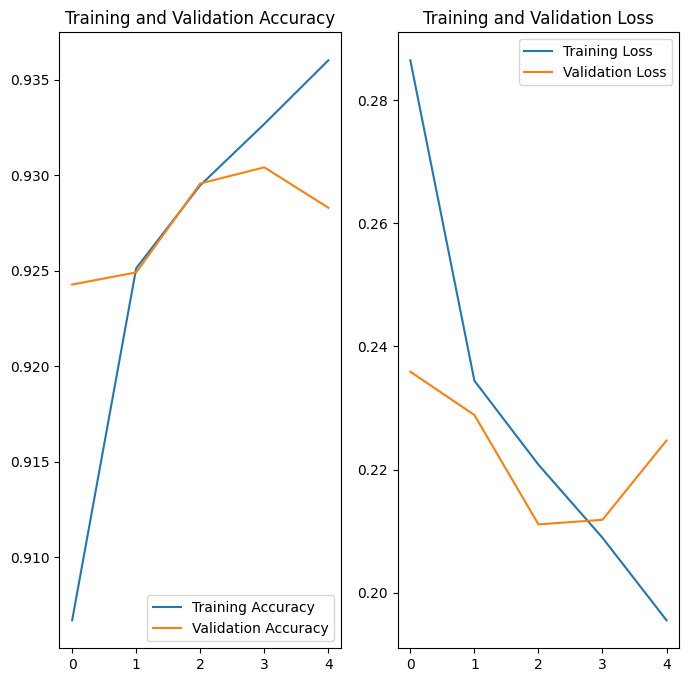

In [143]:
acc = network_history.history['accuracy']
val_acc = network_history.history['val_accuracy']

loss = network_history.history['loss']
val_loss = network_history.history['val_loss']

epochs_range = range(len(network_history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [144]:
from tensorflow.keras.models import load_model
model = load_model("model.hdf5")
test_err = model.evaluate(X_test,Y_test)
print(f"Test loss: {test_err[0]:.2}, Test accuracy: {test_err[1]:.2%}")

output = ['none', 'onset', 'wakeup']
print(output[np.argmax(model.predict(X[1].reshape(1, -1 , 2)))])
print(output[np.argmax(model.predict(X[len(X)//2].reshape(1, -1 , 2)))])
print(output[np.argmax(model.predict(X[-1].reshape(1, -1 , 2)))])

208/208 [==============================] - 1s 3ms/step - loss: 0.2055 - accuracy: 0.9332
Test loss: 0.21, Test accuracy: 93.32%
1/1 [==============================] - 0s 99ms/step
none
1/1 [==============================] - 0s 22ms/step
onset
1/1 [==============================] - 0s 21ms/step
wakeup


In [145]:
X_none = None
X_train = None
X_wakeup = None
X_onset = None
gc.collect()

51269

### Prediction

In [146]:
PRED_STRIDE = 5 * 12
PRED_PROBABILITY_THRESHOLD = 0.99
PRED_MERGE_THRESHOLD = 20 * 12
MIDNIGHT_POINT = 2160

In [147]:
EVT_ONSET = 1
EVT_WAKEUP = 2

In [148]:
test_series = series_map[series_list[0]]


In [149]:
def get_rolling_frames(series):
    n_frames = (series.shape[0] - FRAME_SIZE) // PRED_STRIDE + 1
    centers = np.empty([n_frames])
    frames = np.empty([n_frames, FRAME_SIZE, n_features])
    for idx, frame_start in enumerate(range(0, series.shape[0] - FRAME_SIZE + 1, PRED_STRIDE)):
        frames[idx] = series[frame_start:frame_start + FRAME_SIZE]
        centers[idx] = frame_start + FRAME_SIZE // 2
    return frames, centers

In [150]:
def get_predicted_events(predictions, frame_centers, event_idx):
    predicted_events = []
    for idx, pred in enumerate(predictions):
        p = pred[event_idx] # predicted probability of event
        if p >= PRED_PROBABILITY_THRESHOLD:
            predicted_events.append(frame_centers[idx])
    return predicted_events

In [151]:
def combine_predictions(predictions):
    combined = []
    segment = []
    last = None
    for step in predictions:
        if last != None and step - last > PRED_MERGE_THRESHOLD:
            points = np.array(segment)
            combined.append(points.mean())
            segment.clear()
        segment.append(step)
        last = step
    return combined

In [152]:
def merge_events(onsets, wakeups):
    merged_events = []
    merged_events.extend([(EVT_ONSET, step) for step in onsets])
    merged_events.extend([(EVT_WAKEUP, step) for step in wakeups])
    merged_events.sort(key=lambda event: event[1])
    return merged_events

In [153]:
def fit_sleep_periods(events):
    sleeps = []

    sleep_start = None
    sleep_end = None

    for event, step in events:
        if event == EVT_WAKEUP and sleep_start == None:
            continue
        if event == EVT_ONSET and sleep_start == None:
            sleep_start = step
        if event == EVT_WAKEUP and sleep_start != None:
            sleep_end = step
        if event == EVT_ONSET and sleep_end != None:
            sleeps.append((sleep_start, sleep_end))
            sleep_start = step
            sleep_end = None

    return sleeps

In [154]:
def merge_sleeps(sleeps):
    new_sleeps = []
    last_wakeup = None
    sleep_start = None
    for onset, wakeup in sleeps:
        if last_wakeup is None:
            sleep_start = onset
        elif onset - last_wakeup >= 30 * 12:
            new_sleeps.append((sleep_start, last_wakeup))
            sleep_start = onset
        last_wakeup = wakeup
    if sleep_start is not None:
        new_sleeps.append((sleep_start, last_wakeup))
    return new_sleeps

In [155]:
def assign_to_nights(series_len, start_time, sleep_periods):
    n_nights = (series_len + start_time - MIDNIGHT_POINT) // (24 * 60 * 12) + 1
    sleeps_per_night = [[] for _ in range(0, n_nights)]
    for start, end in sleep_periods:
        mid = int((start + end) / 2)
        night_idx = (mid + start_time - MIDNIGHT_POINT + 12 * 60 * 12) // (24 * 60 * 12)
        sleeps_per_night[night_idx].append((start, end))
    return sleeps_per_night

In [156]:
def filter_max_sleeps(sleeps_nights):
    return [ max(sleeps, key=lambda sleep: sleep[1] - sleep[0]) for sleeps in sleeps_nights if sleeps != []]

In [157]:
def filter_short_sleeps(sleeps):
    return [ (onset, wakeup) for onset, wakeup in sleeps if wakeup - onset >= 30 * 12 ]

In [158]:
test_series = pd.read_parquet(path.join(data_root, 'test_series.parquet'), columns=['series_id', 'timestamp', 'anglez', 'enmo'])
test_series[['anglez', 'enmo']] = input_scaler.transform(test_series[['anglez', 'enmo']])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


#### Visualization of prediction

In [159]:
if not is_submission:
    test_events = pd.read_csv(path.join(data_root, 'test_events.csv'))

In [160]:
def plot_events(series, onset_events, wakeup_events):
    plt.figure(figsize=(200, 4))
    plt.xticks(range(0,series.shape[0], 8640))
    for step in onset_events:
        plt.axvline(step, color='green')
    for step in wakeup_events:
        plt.axvline(step, color='red')
    plt.plot(series, lw=0.5)

In [161]:
def plot_sleep_periods(series, sleeps):
    plt.figure(figsize=(200, 4))
    plt.xticks(range(0,series.shape[0], 8640))
    for sleep in sleeps:
        plt.axvspan(sleep[0], sleep[1], color='green', alpha=0.3)
    plt.plot(series, lw=0.5)
    pass

198/198 [==============================] - 0s 2ms/step


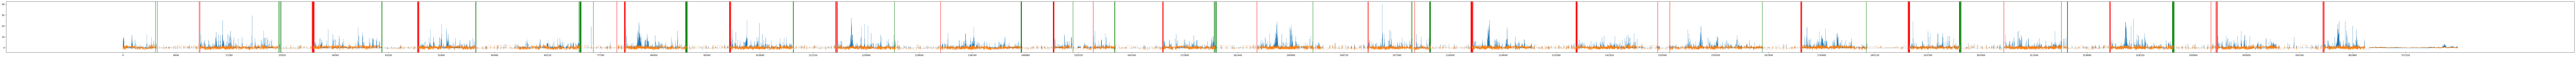

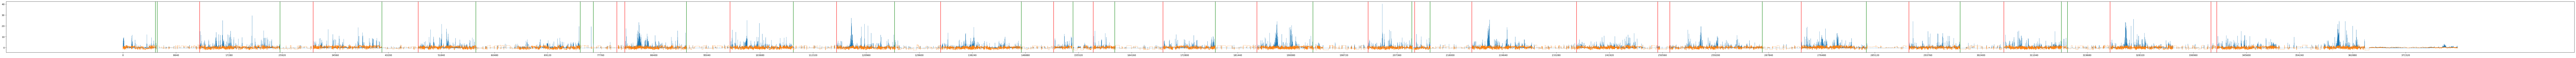

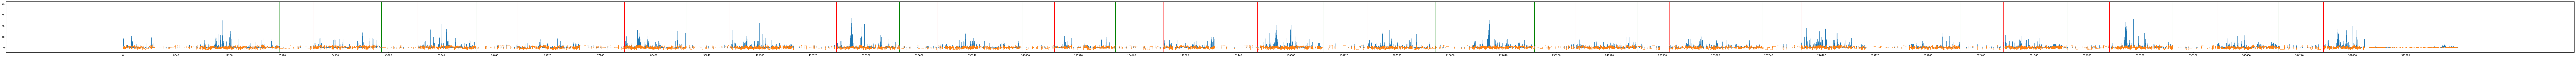

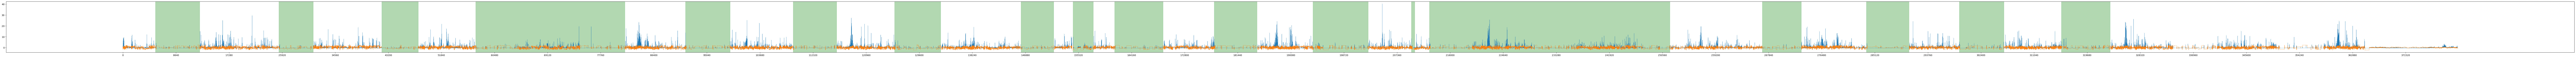

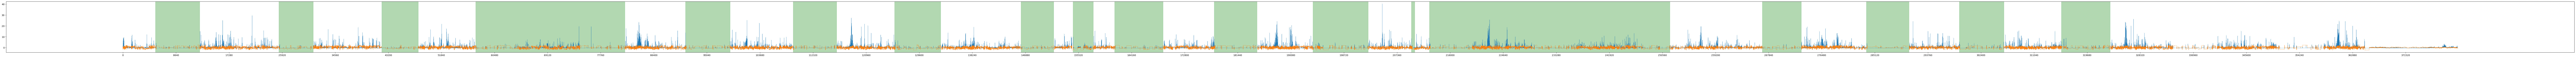

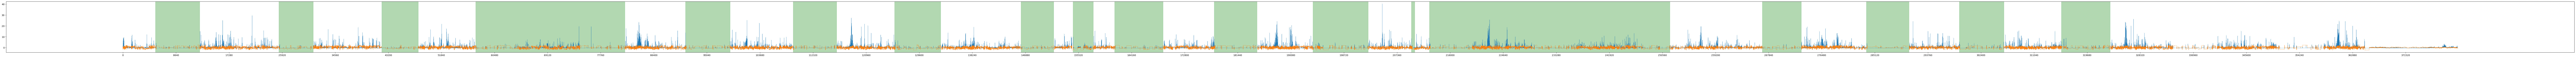

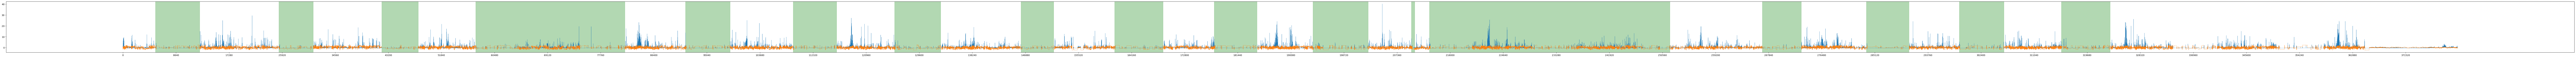

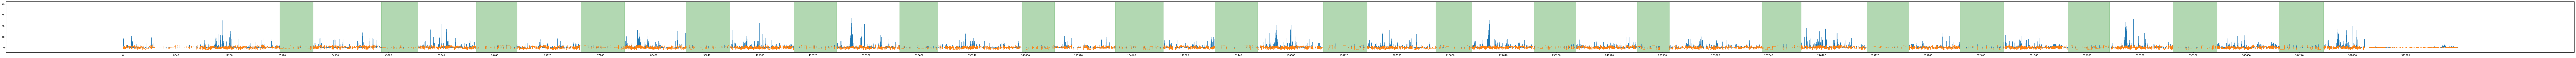

In [162]:
if not is_submission:
    events = test_events[test_events['series_id'] == '4b45c36f8f5a']
    events = events.dropna(axis=0)
    events = events.reset_index(drop=True)
    series = test_series[test_series['series_id'] == '4b45c36f8f5a']
    series = series[['enmo', 'anglez']].to_numpy()

    sleeps_actual = [tuple(e['step']) for night, e in events.groupby('night')]

    onsets_actual = events[events['event'] == 'onset']['step'].to_numpy(dtype=np.int32)
    wakeups_actual = events[events['event'] == 'wakeup']['step'].to_numpy(dtype=np.int32)

    prediction_frames, centers = get_rolling_frames(series)
    predictions = model.predict(prediction_frames)

    onsets_predicted = get_predicted_events(predictions, centers, EVT_ONSET)
    wakeups_predicted = get_predicted_events(predictions, centers, EVT_WAKEUP)

    plot_events(series, onsets_predicted, wakeups_predicted)

    onsets_prediced = combine_predictions(onsets_predicted)
    wakeups_predicted = combine_predictions(wakeups_predicted)

    plot_events(series, onsets_prediced, wakeups_predicted)
    plot_events(series, onsets_actual, wakeups_actual)

    sleeps_predicted = fit_sleep_periods(merge_events(onsets_predicted, wakeups_predicted))

    plot_sleep_periods(series, sleeps_predicted)

    sleeps_predicted = filter_short_sleeps(sleeps_predicted)
    plot_sleep_periods(series, sleeps_predicted)
    sleeps_predicted = merge_sleeps(sleeps_predicted)
    plot_sleep_periods(series, sleeps_predicted)
    sleeps_filtered = filter_max_sleeps(assign_to_nights(len(series), 6120 + 3 * 60 * 12, sleeps_predicted))


    plot_sleep_periods(series, sleeps_filtered)
    plot_sleep_periods(series, sleeps_actual)

#### Prediction of test series

In [163]:
def predict_sleep_periods(series: np.ndarray, start_time) -> list[tuple[int]]:
    prediction_frames, centers = get_rolling_frames(series)
    predictions = model.predict(prediction_frames)

    onsets_predicted = get_predicted_events(predictions, centers, EVT_ONSET)
    wakeups_predicted = get_predicted_events(predictions, centers, EVT_WAKEUP)

    onsets_predicted = combine_predictions(onsets_predicted)
    wakeups_predicted = combine_predictions(wakeups_predicted)

    sleeps_predicted = fit_sleep_periods(merge_events(onsets_predicted, wakeups_predicted))

    sleeps_predicted = filter_short_sleeps(sleeps_predicted)
    sleeps_predicted = merge_sleeps(sleeps_predicted)

    sleeps_filtered = filter_max_sleeps(assign_to_nights(len(series), start_time, sleeps_predicted))
    sleeps_filtered = filter_short_sleeps(sleeps_filtered)
    return sleeps_filtered

In [164]:
def create_submission_df(series_id, sleeps):
    submission = None
    for onset, wakeup in sleeps:
        sleep_df = pd.DataFrame([
            {'series_id': series_id, 'step': onset, 'event': 'onset', 'score': 1.0},
            {'series_id': series_id, 'step': wakeup, 'event': 'wakeup', 'score': 1.0}
        ])
        if submission is None:
            submission = sleep_df
        else:
            submission = pd.concat([submission, sleep_df], ignore_index=True)
    return submission

In [165]:
from datetime import datetime

In [166]:
submission = None
for series_id, s in test_series.groupby('series_id'):
    series = s.reset_index(drop=True)
    if (len(series) < FRAME_SIZE):
        continue
    first_timestamp = series['timestamp'][0]
    first_timestamp = datetime.strptime(first_timestamp[:-5], '%Y-%m-%dT%H:%M:%S')
    first_step_time = (first_timestamp.hour * 3600 + first_timestamp.minute * 60 + first_timestamp.second) // 5
    series_data = series[['enmo', 'anglez']].reset_index(drop=True).to_numpy()
    sleeps = predict_sleep_periods(series_data, first_step_time)
    sleeps_df = create_submission_df(series_id, sleeps)
    if submission is None:
        submission = sleeps_df
    else:
        submission = pd.concat([submission, sleeps_df], ignore_index=True)

210/210 [==============================] - 0s 2ms/step


#### Evaluation using Event Detection AP

In [168]:
from evalutation import score

if not is_submission:
    tolerances = {"onset": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
             "wakeup": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}
    print(score(test_events, submission, tolerances, "series_id", "step", "event", "score"))

0.2173401922752572


#### Writing submission

In [169]:
display(submission)

series_id      step   event  score
0    05e1944c3818    3000.0   onset    1.0
1    05e1944c3818    9930.0  wakeup    1.0
2    05e1944c3818   20460.0   onset    1.0
3    05e1944c3818   45330.0  wakeup    1.0
4    05e1944c3818   55350.0   onset    1.0
..            ...       ...     ...    ...
919  f88e18cb4100  340530.0  wakeup    1.0
920  f88e18cb4100  363600.0   onset    1.0
921  f88e18cb4100  364470.0  wakeup    1.0
922  f88e18cb4100  370500.0   onset    1.0
923  f88e18cb4100  374760.0  wakeup    1.0

[924 rows x 4 columns]

In [170]:
if submission is not None:
    submission.to_csv('submission.csv', index_label='row_id')